## 多输⼊多输出通道
虽然在之前描述了构成每个图像的多个通道和多层卷积层。例如彩⾊图像具有标准的RGB通道来
代表红、绿和蓝。但是到⽬前为⽌，我们仅展⽰了单个输⼊和单个输出通道的简化例⼦。这使得我们可以将
输⼊、卷积核和输出看作⼆维张量。

当我们添加通道时，我们的输⼊和隐藏的表⽰都变成了三维张量。例如，每个RGB输⼊图像具有3 × h × w的
形状。我们将这个⼤⼩为3的轴称为通道（channel）维度。本节将更深⼊地研究具有多输⼊和多输出通道的
卷积核。


## 多输入通道
在下图中，我们演⽰了⼀个具有两个输⼊通道的⼆维互相关运算的⽰例。阴影部分是第⼀个输出元素以及
⽤于计算这个输出的输⼊和核张量元素：(1 × 1 + 2 × 2 + 4 × 3 + 5 × 4) + (0 × 0 + 1 × 1 + 3 × 2 + 4 × 3) = 56。  

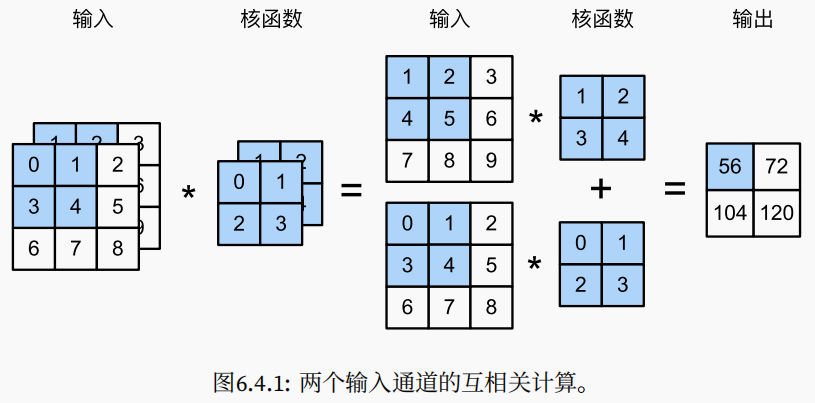

为了加深理解，实现⼀下多输⼊通道互相关运算。简⽽⾔之，我们所做的就是对每个通道执⾏互相关操
作，然后将结果相加。

In [1]:
import torch
from d2l import torch as d2l

def corr2d_multi_in(X, K):
    # 先遍历“X”和“K”的第0个维度（通道维度），再把它们加在⼀起
    return sum(d2l.corr2d(x, k) for x, k in zip(X, K))

可以构造与上图中的值相对应的输⼊张量X和核张量K，以验证互相关运算的输出。


In [2]:
X = torch.tensor([[[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]],
                [[1.0, 2.0, 3.0], [4.0, 5.0, 6.0], [7.0, 8.0, 9.0]]])
K = torch.tensor([[[0.0, 1.0], [2.0, 3.0]], [[1.0, 2.0], [3.0, 4.0]]])
corr2d_multi_in(X, K)

tensor([[ 56.,  72.],
        [104., 120.]])

## 多输出通道
到⽬前为⽌，不论有多少输⼊通道，我们还只有⼀个输出通道。然⽽，正如我们在上面所讨论的，每⼀
层有多个输出通道是⾄关重要的。在最流⾏的神经⽹络架构中，随着神经⽹络层数的加深，我们常会增加输
出通道的维数，通过减少空间分辨率以获得更⼤的通道深度。直观地说，我们可以将每个通道看作对不同特
征的响应。⽽现实可能更为复杂⼀些，因为每个通道不是独⽴学习的，⽽是为了共同使⽤⽽优化的。因此，多
输出通道并不仅是学习多个单通道的检测器。

⽤ci和co分别表⽰输⼊和输出通道的数⽬，并让kh和kw为卷积核的⾼度和宽度。为了获得多个通道的输出，我
们可以为每个输出通道创建⼀个形状为ci × kh × kw的卷积核张量，这样卷积核的形状是co × ci × kh × kw。在
互相关运算中，每个输出通道先获取所有输⼊通道，再以对应该输出通道的卷积核计算出结果。  

如下所⽰，我们实现⼀个计算多个通道的输出的互相关函数。

In [3]:
def corr2d_multi_in_out(X, K):
    # 迭代“K”的第0个维度，每次都对输⼊“X”执⾏互相关运算。
    # 最后将所有结果都叠加在⼀起
    return torch.stack([corr2d_multi_in(X, k) for k in K], 0)

通过将核张量K与K+1（K中每个元素加1）和K+2连接起来，构造了⼀个具有3个输出通道的卷积核。

In [4]:
K = torch.stack((K, K + 1, K + 2), 0)
K.shape

torch.Size([3, 2, 2, 2])

下⾯，我们对输⼊张量X与卷积核张量K执⾏互相关运算。现在的输出包含3个通道，第⼀个通道的结果与先前
输⼊张量X和多输⼊单输出通道的结果⼀致。

In [5]:
corr2d_multi_in_out(X, K)

tensor([[[ 56.,  72.],
         [104., 120.]],

        [[ 76., 100.],
         [148., 172.]],

        [[ 96., 128.],
         [192., 224.]]])

## 1x1卷积层
1 × 1卷积，即kh = kw = 1，看起来似乎没有多⼤意义。毕竟，卷积的本质是有效提取相邻像素间的相关特
征，⽽1 × 1卷积显然没有此作⽤。尽管如此，1 × 1仍然⼗分流⾏，经常包含在复杂深层⽹络的设计中。下⾯，
让我们详细地解读⼀下它的实际作⽤。

因为使⽤了最⼩窗⼝，1 × 1卷积失去了卷积层的特有能⼒——在⾼度和宽度维度上，识别相邻元素间相互作
⽤的能⼒。其实1 × 1卷积的唯⼀计算发⽣在通道上。  

下图展⽰了使⽤1×1卷积核与3个输⼊通道和2个输出通道的互相关计算。这⾥输⼊和输出具有相同的⾼度
和宽度，输出中的每个元素都是从输⼊图像中同⼀位置的元素的线性组合。我们可以将1 × 1卷积层看作在每
个像素位置应⽤的全连接层，以ci个输⼊值转换为co个输出值。因为这仍然是⼀个卷积层，所以跨像素的权
重是⼀致的。同时，1 × 1卷积层需要的权重维度为co × ci，再额外加上⼀个偏置。  

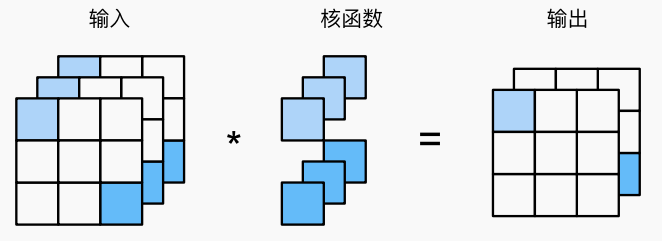

上图是互相关计算使⽤了具有3个输⼊通道和2个输出通道的 1 × 1 卷积核。其中，输⼊和输出具有相同的⾼
度和宽度。  

下⾯，使⽤全连接层实现1 × 1卷积。请注意，我们需要对输⼊和输出的数据形状进⾏调整。

In [6]:
def corr2d_multi_in_out_1x1(X, K):
    c_i, h, w = X.shape
    c_o = K.shape[0]
    X = X.reshape((c_i, h * w))
    K = K.reshape((c_o, c_i))
    # 全连接层中的矩阵乘法
    Y = torch.matmul(K, X)
    return Y.reshape((c_o, h, w))

当执⾏1 × 1卷积运算时，上述函数相当于先前实现的互相关函数corr2d_multi_in_out。让我们⽤⼀些样本
数据来验证这⼀点。

In [10]:
X = torch.normal(0, 1, (3, 3, 3))
K = torch.normal(0, 1, (2, 3, 1, 1))
print(X)
print(K)

tensor([[[-0.4859, -0.1219, -0.1335],
         [ 0.3182,  0.6541, -0.5690],
         [-0.0790,  0.6681,  0.4966]],

        [[-0.7220, -0.7312, -1.0255],
         [ 1.7408,  0.7761,  1.9133],
         [-1.7060, -1.1879,  0.6146]],

        [[-0.2978,  1.2429,  1.1824],
         [-0.3675,  0.1623,  0.7613],
         [-0.1301, -0.2909, -0.2406]]])
tensor([[[[-0.0103]],

         [[ 1.0867]],

         [[-0.6389]]],


        [[[-1.0090]],

         [[ 2.2067]],

         [[-1.5066]]]])


In [15]:
Y1 = corr2d_multi_in_out_1x1(X, K)
Y2 = corr2d_multi_in_out(X, K)
assert float(torch.abs(Y1 - Y2).sum()) < 1e-6
print(Y1)
print(Y2)

print(float(torch.abs(Y1 - Y2).sum()))

tensor([[[-0.5894, -1.5874, -1.8686],
         [ 2.1233,  0.7330,  1.5987],
         [-1.7701, -1.1120,  0.8166]],

        [[-0.6543, -3.3631, -3.9098],
         [ 4.0740,  0.8080,  3.6491],
         [-3.4889, -2.8573,  1.2177]]])
tensor([[[-0.5894, -1.5874, -1.8686],
         [ 2.1233,  0.7330,  1.5987],
         [-1.7701, -1.1120,  0.8166]],

        [[-0.6543, -3.3631, -3.9098],
         [ 4.0740,  0.8080,  3.6491],
         [-3.4889, -2.8573,  1.2177]]])
0.0


## 小结
* 多输⼊多输出通道可以⽤来扩展卷积层的模型。
* 当以每像素为基础应⽤时，1 × 1卷积层相当于全连接层。
* 1 × 1卷积层通常⽤于调整⽹络层的通道数量和控制模型复杂性。